In [1]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np
import random

In [3]:
problem = DTLZ2(n_obj=2)
ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=50)

In [4]:
output = {}
problem._evaluate(ref_dirs,output)

In [5]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
x1 = [i[0] for i in ref_dirs]
x2 = [i[1] for i in ref_dirs]
dict_data = {}

dict_data['x1'] = x1
dict_data['x2'] = x2
dict_data['Objective 1']  = objective_value_1
dict_data['Objective 2'] = objective_value_2
dataset = pd.DataFrame(data=dict_data)

In [6]:
dataset.head()

,x1,x2,Objective 1,Objective 2
0,0.00,1.00,1.250000,0.000000
1,0.02,0.98,1.229793,0.038648
2,0.04,0.96,1.209209,0.076077
3,0.06,0.94,1.188303,0.112328
4,0.08,0.92,1.167124,0.147442


##### MOdelling on Objective 1

In [7]:
X = dataset[['x1','x2']].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [8]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
kernel =  RBF(length_scale=3) 
model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=25,normalize_y=True).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [9]:
x1 = dataset['x1'].to_numpy()
x2= dataset['x2'].to_numpy()
x1 = np.linspace(x1.min(), x2.max())
x2 = np.linspace(x2.min(), x1.max())

In [10]:
x= (np.array([x1,x2])).T
output = {}
problem._evaluate(x,output)
data = [i[0] for i in output['F']]

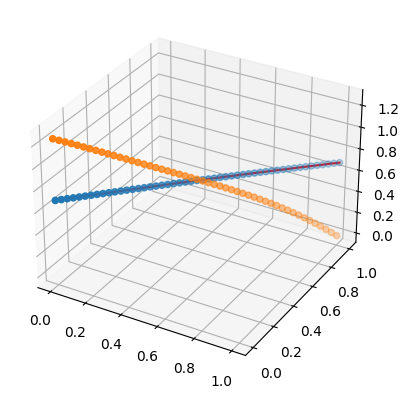

In [11]:
ax = plt.figure().add_subplot(projection='3d')
mean,std = model.predict(x,return_std=True)
ax.scatter(x1,x2,mean)
ax.scatter(x1,x2,data)
ax.plot(x1,x2,mean,color = 'red')


In [12]:
kernel_2 = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=11).fit(X,Y)
output = {}
x= (np.array([x1,x2])).T
problem._evaluate(x,output)
data = [i[0] for i in output['F']]

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


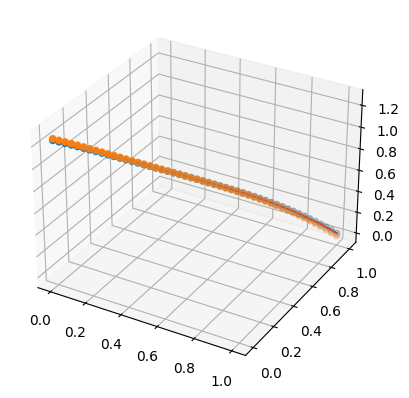

In [13]:
x1 = dataset['x1'].to_numpy()
x2= dataset['x2'].to_numpy()
x1 = np.linspace(x1.min(), x2.max())
x2 = np.linspace(x2.min(), x1.max())
ax = plt.figure().add_subplot(projection='3d')
x= (np.array([x1,x2])).T
mean_2,std_2 = model_2.predict(x,return_std=True)
ax.scatter(x1,x2,mean_2)
ax.scatter(x1,x2,data)
ax.plot(x1,x2,mean_2,color = 'red')


#### Model on Objective 2

In [14]:
X = dataset[['x1','x2']].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=12).fit(X,Y)

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


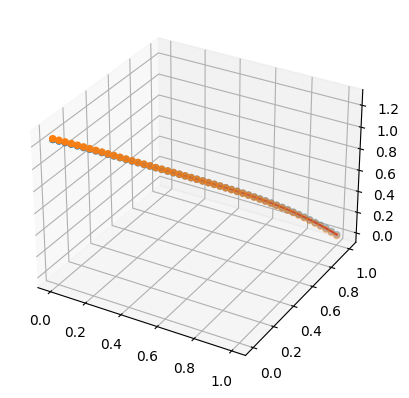

In [15]:
x1 = dataset['x1'].to_numpy()
x2= dataset['x2'].to_numpy()
x1 = np.linspace(x1.min(), x2.max())
x2 = np.linspace(x2.min(), x1.max())
ax = plt.figure().add_subplot(projection='3d')
x= (np.array([x1,x2])).T
output = {}
x= (np.array([x1,x2])).T
problem._evaluate(x,output)
data = [i[0] for i in output['F']]
mean_2,std_2 = model_3.predict(x,return_std=True)
ax.scatter(x1,x2,mean_2)
ax.scatter(x1,x2,data)
ax.plot(x1,x2,mean_2,color = 'red')


In [16]:
value = np.array([0.1,0.9])
value = value.reshape(1,-1)

mean,std = model_3.predict(value,return_std=True)

#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [17]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,std_1,mean,std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],std_1[i],mean[i],std[i]])
        out["F"] = objective_values

In [18]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [22]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [23]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm = NSGA2(pop_size = 100)
data = []
for i in range(10):
    data.append(epsilon_greedy_method(0.4,problem_1,problem_2,algorithm))



In [27]:
data[0]

array([0.60524171, 0.10540935])

In [31]:
data = [list(i) for i  in data]
data_x1 = list(dataset['x1'])
data_x2 = list(dataset['x2'])
data_new_x1  = [i[0] for i in data]
data_new_x2  = [i[1] for i in data]
new_data_x1  = data_x1 + data_new_x1
new_data_x2  = data_x2 + data_new_x2
data_obj_1   = list(dataset['Objective 1'])
data_obj_2   = list(dataset['Objective 2'])
output = {}
new_objectives  = problem._evaluate(data,output)
new_obj1 = [i[0] for i in output['F']] + data_obj_1
new_obj2 = [i[1] for i in output['F']] + data_obj_2
dict_data = {}
dict_data['x1'] = new_data_x1
dict_data['x2'] = new_data_x2
dict_data['Objective 1']  = new_obj1
dict_data['Objective 2'] = new_obj2
new_dataset = pd.DataFrame(dict_data)


TypeError: list indices must be integers or slices, not tuple